## 1. Подготовка данных

1. проверить наличие пропусков и выбросов

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('../datasets/insurance_train.csv')
test_df = pd.read_csv('../datasets/insurance_test.csv')

print(f"\nРазмер тренировочных данных: {train_df.shape}")
print(f"\nКоличество пропусков:")
print(train_df.isnull().sum())

print("\n" + "="*50 + "\n")

print(f"\nРазмер тестовых данных: {test_df.shape}")
print(f"\nКоличество пропусков:")
print(test_df.isnull().sum())


Размер тренировочных данных: (338, 7)

Количество пропусков:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64



Размер тестовых данных: (1000, 7)

Количество пропусков:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64



age:
  Нижняя граница: -7.50
  Верхняя граница: 84.50
  Выбросов обнаружено: 0 (0.00%)

bmi:
  Нижняя граница: 13.24
  Верхняя граница: 47.41
  Выбросов обнаружено: 5 (1.48%)

children:
  Нижняя граница: -3.00
  Верхняя граница: 5.00
  Выбросов обнаружено: 0 (0.00%)

charges:
  Нижняя граница: -17107.29
  Верхняя граница: 41342.29
  Выбросов обнаружено: 19 (5.62%)


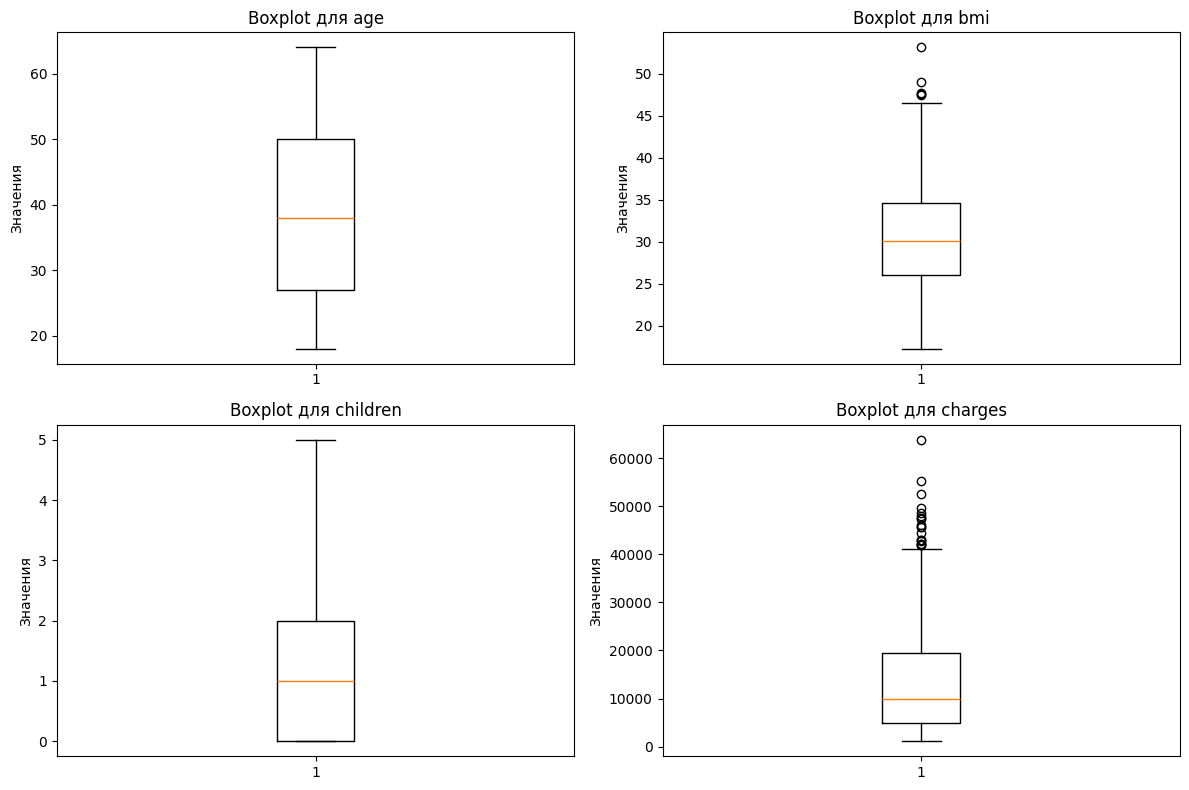

In [40]:
# Анализ числовых признаков
numeric_features = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    axes[i].boxplot(train_df[feature])
    axes[i].set_title(f'Boxplot для {feature}')
    axes[i].set_ylabel('Значения')
    
    # Определение выбросов с помощью IQR
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"  Нижняя граница: {lower_bound:.2f}")
    print(f"  Верхняя граница: {upper_bound:.2f}")
    print(f"  Выбросов обнаружено: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")

plt.tight_layout()
plt.show()

2. привести категориальные признаки к числовым

In [41]:
train_processed = train_df.copy()
test_processed = test_df.copy()

def encode_categorical(df):
    df_encoded = df.copy()
    
    df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
    df_encoded['smoker'] = df_encoded['smoker'].map({'no': 0, 'yes': 1})
    
    region_dummies = pd.get_dummies(df_encoded['region'], prefix='region', drop_first=True)
    df_encoded = pd.concat([df_encoded.drop('region', axis=1), region_dummies], axis=1)
    
    return df_encoded

train_encoded = encode_categorical(train_processed)
test_encoded = encode_categorical(test_processed)

print("Первые 5 строк тренировочных данных:")
print(train_encoded.head())

# Разделение на признаки и целевую переменную
X_train = train_encoded.drop('charges', axis=1).values
y_train = train_encoded['charges'].values
X_test = test_encoded.drop('charges', axis=1).values
y_test = test_encoded['charges'].values

print(f"\nРазмеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Первые 5 строк тренировочных данных:
   age  sex     bmi  children  smoker      charges  region_northwest  \
0   26    0  27.060         0       1  17043.34140             False   
1   58    0  36.955         2       1  47496.49445              True   
2   20    1  24.420         0       1  26125.67477             False   
3   51    1  38.060         0       1  44400.40640             False   
4   62    1  25.000         0       0  13451.12200             False   

   region_southeast  region_southwest  
0              True             False  
1             False             False  
2              True             False  
3              True             False  
4             False              True  

Размеры данных:
X_train: (338, 8), y_train: (338,)
X_test: (1000, 8), y_test: (1000,)


3. вычислить парные корреляции признаков


Корреляция с charges:
  charges: 1.00000
  smoker: 0.78352
  age: 0.29840
  bmi: 0.21957
  children: 0.06944
  region_southeast: 0.00979
  region_northwest: -0.03229
  region_southwest: -0.05391
  sex: -0.06022


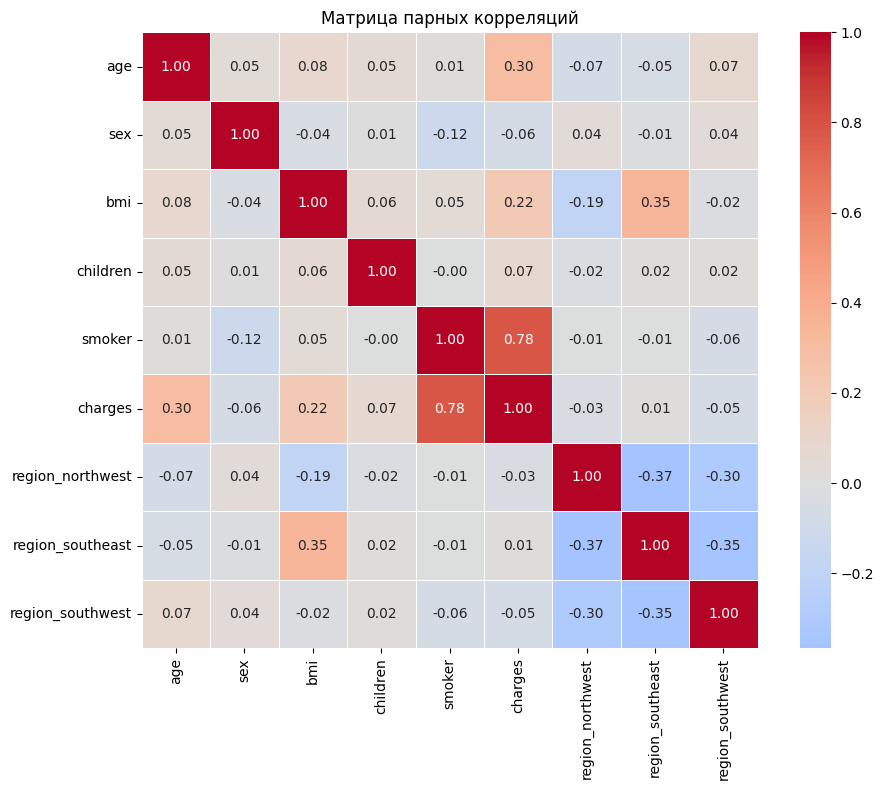

In [42]:

correlation_df = train_encoded.copy()
correlation_matrix = correlation_df.corr()

print("\nКорреляция с charges:")
charges_corr = correlation_matrix['charges'].sort_values(ascending=False)
for feature, corr_value in charges_corr.items():
    print(f"  {feature}: {corr_value:.5f}")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Матрица парных корреляций')
plt.tight_layout()
plt.show()

## 2. Многомерная линейная регрессия

In [43]:

print("ЛИНЕЙНАЯ РЕГРЕССИЯ - АНАЛИТИЧЕСКОЕ РЕШЕНИЕ")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_with_intercept = add_intercept(X_train_scaled)
X_test_with_intercept = add_intercept(X_test_scaled)

# Аналитическое решение: w = (X^T X)^(-1) X^T y
def analytical_linear_regression(X, y):
    try:
        weights = np.linalg.inv(X.T @ X) @ X.T @ y
    except np.linalg.LinAlgError:
        # Если матрица вырождена, используем псевдообратную
        weights = np.linalg.pinv(X.T @ X) @ X.T @ y
    
    return weights

def predict_linear(X, weights):
    return X @ weights

weights_analytical = analytical_linear_regression(X_train_with_intercept, y_train)

print("\nВЕСА МОДЕЛИ (аналитическое решение):")
feature_names = ['intercept'] + list(train_encoded.drop('charges', axis=1).columns)
for name, weight in zip(feature_names, weights_analytical):
    print(f"  {name:20}: {weight:10.2f}")



y_pred_train_analytical = predict_linear(X_train_with_intercept, weights_analytical)
mse_train_analytical = np.mean((y_train - y_pred_train_analytical) ** 2)
mae_train_analytical = np.mean(np.abs(y_train - y_pred_train_analytical))
r2_train_analytical = 1 - np.sum((y_train - y_pred_train_analytical) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)

print(f"\nКАЧЕСТВО НА ТРЕНИРОВОЧНЫХ ДАННЫХ:")
print(f"  MSE:  {mse_train_analytical:,.0f}")
print(f"  MAE:  {mae_train_analytical:,.0f}")
print(f"  R²:   {r2_train_analytical:.3f}")

ЛИНЕЙНАЯ РЕГРЕССИЯ - АНАЛИТИЧЕСКОЕ РЕШЕНИЕ

ВЕСА МОДЕЛИ (аналитическое решение):
  intercept           :   14092.86
  age                 :    3495.77
  sex                 :     327.42
  bmi                 :    2210.57
  children            :     581.68
  smoker              :    9859.85
  region_northwest    :     -85.26
  region_southeast    :    -638.00
  region_southwest    :    -601.39

КАЧЕСТВО НА ТРЕНИРОВОЧНЫХ ДАННЫХ:
  MSE:  44,325,092
  MAE:  4,696
  R²:   0.728


ЛИНЕЙНАЯ РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК
  Итерация    0: MSE = 361,771,952
  Итерация  100: MSE = 62,883,297
  Итерация  200: MSE = 46,427,845
  Итерация  300: MSE = 44,619,760
  Итерация  400: MSE = 44,370,872
  Итерация  500: MSE = 44,333,405
  Итерация  600: MSE = 44,327,114
  Итерация  700: MSE = 44,325,807
  Итерация  800: MSE = 44,325,422
  Итерация  900: MSE = 44,325,264
  Итерация 1000: MSE = 44,325,185
  Итерация 1100: MSE = 44,325,143
  Итерация 1200: MSE = 44,325,120
  Итерация 1300: MSE = 44,325,108
  Итерация 1400: MSE = 44,325,101
  Итерация 1500: MSE = 44,325,097
  Итерация 1600: MSE = 44,325,095
  Итерация 1700: MSE = 44,325,093
  Итерация 1800: MSE = 44,325,093
  Итерация 1900: MSE = 44,325,092
  Итерация 2000: MSE = 44,325,092
  Итерация 2100: MSE = 44,325,092
  Итерация 2200: MSE = 44,325,092
  Итерация 2300: MSE = 44,325,092
  Итерация 2400: MSE = 44,325,092
  Итерация 2500: MSE = 44,325,092
  Итерация 2600: MSE = 44,325,092
  Итерация 2700: MSE = 44,325,092
  Итерац

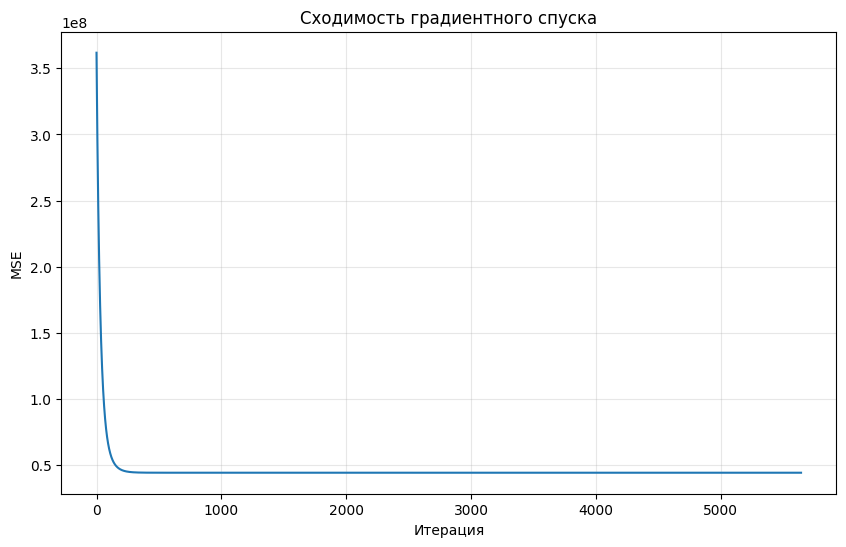


3. РЕЗУЛЬТАТЫ МОДЕЛИ:
  MSE: 44,325,092
  Количество итераций: 5645


In [44]:
print("ЛИНЕЙНАЯ РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК")

class GDLinearRegression:
    def __init__(self, learning_rate=0.01, tolerance=1e-8, track_history=True):
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.track_history = track_history
        self.mse_history = [] if track_history else None
    
    def fit(self, X, y, verbose=True):
        n_samples, n_features = X.shape
        self.bias, self.weights = 0, np.zeros(n_features)
        previous_db, previous_dw = 0, np.zeros(n_features)
        
        iteration = 0
        
        while True:
            y_pred = X @ self.weights + self.bias
            
            if self.track_history:
                mse = np.mean((y - y_pred) ** 2)
                self.mse_history.append(mse)
                
                if verbose and iteration % 100 == 0:
                    print(f"  Итерация {iteration:4d}: MSE = {mse:,.0f}")
            
            db = 1 / n_samples * np.sum(y_pred - y)
            dw = 1 / n_samples * X.T @ (y_pred - y)
            self.bias -= self.learning_rate * db
            self.weights -= self.learning_rate * dw
            
            abs_db_reduction = np.abs(db - previous_db)
            abs_dw_reduction = np.abs(dw - previous_dw)
            
            if abs_db_reduction < self.tolerance:
                if (abs_dw_reduction < self.tolerance).all():
                    if verbose and self.track_history:
                        print(f"  Итерация {iteration:4d}: MSE = {mse:,.0f} (сходимость достигнута)")
                    break
            
            previous_db = db
            previous_dw = dw
            iteration += 1
    
    def predict(self, X_test):
        return X_test @ self.weights + self.bias
    

gd_model = GDLinearRegression(learning_rate=0.01, tolerance=1e-8)
gd_model.fit(X_train_with_intercept, y_train)

# Визуализация сходимости градиентного спуска
plt.figure(figsize=(10, 6))
plt.plot(gd_model.mse_history)
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.title('Сходимость градиентного спуска')
plt.grid(True, alpha=0.3)
plt.show()

# Предсказания альтернативной моделью
y_pred_train_gd_hist = gd_model.predict(X_train_with_intercept)
mse_train_gd_hist = np.mean((y_train - y_pred_train_gd_hist) ** 2)

print(f"\n3. РЕЗУЛЬТАТЫ МОДЕЛИ:")
print(f"  MSE: {mse_train_gd_hist:,.0f}")
print(f"  Количество итераций: {len(gd_model.mse_history)}")

## 3. Добавление регуляризации

In [45]:
print("RIDGE РЕГРЕССИЯ - АНАЛИТИЧЕСКОЕ РЕШЕНИЕ")

def analytical_ridge_regression(X, y, alpha=1.0):
    n_features = X.shape[1]
    
    regularization_matrix = alpha * np.eye(n_features)
    regularization_matrix[0, 0] = 0
    
    try:
        # Решение: w = (X^T X + αI)^(-1) X^T y
        weights = np.linalg.inv(X.T @ X + regularization_matrix) @ X.T @ y
    except np.linalg.LinAlgError:
        weights = np.linalg.pinv(X.T @ X + regularization_matrix) @ X.T @ y
    
    return weights

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []

print("\nПОДБОР ОПТИМАЛЬНОГО ALPHA:")

for alpha in alphas:
    weights_ridge = analytical_ridge_regression(X_train_with_intercept, y_train, alpha)
    y_pred_ridge = predict_linear(X_train_with_intercept, weights_ridge)
    mse = np.mean((y_train - y_pred_ridge) ** 2)
    results.append((alpha, mse, weights_ridge))
    
    print(f"  alpha = {alpha:7.3f}: MSE = {mse:,.0f}")

# Выбор лучшего alpha
best_alpha, best_mse, best_weights_ridge = min(results, key=lambda x: x[1])

print(f"\nЛУЧШИЙ ПАРАМЕТР:")
print(f"  alpha: {best_alpha}")
print(f"  MSE:   {best_mse:,.0f}")

print(f"\nВЕСА ЛУЧШЕЙ RIDGE МОДЕЛИ:")
for name, weight in zip(feature_names, best_weights_ridge):
    print(f"  {name:20}: {weight:10.2f}")


print(f"\nСРАВНЕНИЕ ВЕСОВ C ОБЫЧНОЙ ЛИНЕЙНОЙ РЕГРЕССИЕЙ:")
print(f"{'Признак':20} {'Linear':>10} {'Ridge':>10} {'Разница':>10}")
print("-"*60)

for i, name in enumerate(feature_names):
    linear_weight = weights_analytical[i]
    ridge_weight = best_weights_ridge[i]
    diff = abs(linear_weight - ridge_weight)
    print(f"{name:20} {linear_weight:10.2f} {ridge_weight:10.2f} {diff:10.2f}")

RIDGE РЕГРЕССИЯ - АНАЛИТИЧЕСКОЕ РЕШЕНИЕ

ПОДБОР ОПТИМАЛЬНОГО ALPHA:
  alpha =   0.001: MSE = 44,325,092
  alpha =   0.010: MSE = 44,325,092
  alpha =   0.100: MSE = 44,325,102
  alpha =   1.000: MSE = 44,326,087
  alpha =  10.000: MSE = 44,419,489
  alpha = 100.000: MSE = 50,282,609
  alpha = 1000.000: MSE = 109,387,496

ЛУЧШИЙ ПАРАМЕТР:
  alpha: 0.001
  MSE:   44,325,092

ВЕСА ЛУЧШЕЙ RIDGE МОДЕЛИ:
  intercept           :   14092.86
  age                 :    3495.76
  sex                 :     327.42
  bmi                 :    2210.57
  children            :     581.67
  smoker              :    9859.82
  region_northwest    :     -85.26
  region_southeast    :    -638.00
  region_southwest    :    -601.39

СРАВНЕНИЕ ВЕСОВ C ОБЫЧНОЙ ЛИНЕЙНОЙ РЕГРЕССИЕЙ:
Признак                  Linear      Ridge    Разница
------------------------------------------------------------
intercept              14092.86   14092.86       0.00
age                     3495.77    3495.76       0.01
sex         

In [46]:
print("RIDGE РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК")

class GDRidgeRegression:
    def __init__(self, alpha=1.0, learning_rate=0.01, tolerance=1e-8, track_history=True, 
                 max_iterations=10000):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.track_history = track_history
        self.max_iterations = max_iterations
        self.mse_history = [] if track_history else None
    
    def fit(self, X, y, verbose=False):
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        
        iteration = 0
        previous_gradient = np.zeros(n_features)
        converged = False
        
        while iteration < self.max_iterations and not converged:
            # Прямое распространение
            y_pred = X @ self.weights
            
            # Вычисление MSE с регуляризацией L2
            mse_with_reg = np.mean((y - y_pred) ** 2) + self.alpha * np.sum(self.weights[1:]**2) / n_samples
            
            # Запись истории
            if self.track_history:
                self.mse_history.append(mse_with_reg)
                
                # Вывод прогресса
                if verbose and iteration % 100 == 0:
                    print(f"  Итерация {iteration:4d}: MSE+Reg = {mse_with_reg:,.0f}")
            
            # Градиент с регуляризацией
            # Часть без регуляризации
            gradient = -(2/n_samples) * X.T @ (y - y_pred)
            # Добавляем регуляризацию для всех весов, кроме свободного члена
            gradient[1:] += (2 * self.alpha / n_samples) * self.weights[1:]
            
            # Обновление весов
            self.weights -= self.learning_rate * gradient
            
            # Проверка сходимости
            gradient_change = np.linalg.norm(gradient - previous_gradient)
            if gradient_change < self.tolerance:
                if verbose:
                    print(f"  Итерация {iteration:4d}: сходимость достигнута (изменение градиента: {gradient_change:.6f})")
                converged = True
            
            previous_gradient = gradient.copy()
            iteration += 1
        
        if not converged and verbose:
            print(f"  Достигнут максимум итераций ({self.max_iterations})")
        
        self.n_iterations = iteration
        return self
    
    def predict(self, X):
        return X @ self.weights
    
    def get_coefficients(self):
        return self.weights
    
    def get_history(self):
        return self.mse_history
    
    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)
    
    print("RIDGE РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК (ПОДБОР ALPHA)")

alphas_gd = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results_gd = []

print("\nПОДБОР ОПТИМАЛЬНОГО ALPHA (ГРАДИЕНТНЫЙ СПУСК):")

for alpha in alphas_gd:
    # Создаем и обучаем модель с текущим alpha
    model = GDRidgeRegression(
        alpha=alpha,
        learning_rate=0.01,
        tolerance=1e-8,
        track_history=False,  # Отключаем историю для ускорения
        max_iterations=10000
    )
    
    # Обучаем модель
    model.fit(X_train_with_intercept, y_train, verbose=False)
    
    # Получаем предсказания и MSE
    y_pred_gd = model.predict(X_train_with_intercept)
    mse_gd = np.mean((y_train - y_pred_gd) ** 2)
    
    # Сохраняем результаты
    weights_gd = model.get_coefficients()
    results_gd.append((alpha, mse_gd, weights_gd, model))
    
    print(f"  alpha = {alpha:7.3f}: MSE = {mse_gd:,.0f}, Итераций: {model.n_iterations}")

# Выбор лучшего alpha
best_alpha_gd, best_mse_gd, best_weights_gd, best_model_gd = min(results_gd, key=lambda x: x[1])

print(f"\nЛУЧШИЙ ПАРАМЕТР (ГРАДИЕНТНЫЙ СПУСК):")
print(f"  alpha:      {best_alpha_gd}")
print(f"  MSE:        {best_mse_gd:,.0f}")
print(f"  Итераций:   {best_model_gd.n_iterations}")

print(f"\nВЕСА ЛУЧШЕЙ RIDGE МОДЕЛИ (ГРАДИЕНТНЫЙ СПУСК):")
for name, weight in zip(feature_names, best_weights_gd):
    print(f"  {name:20}: {weight:10.2f}")

print(f"\nСРАВНЕНИЕ МЕТОДОВ:")
print(f"{'Признак':20} {'Аналит.':>10} {'Град.спуск':>10} {'Разница':>10}")
print("-"*60)

for i, name in enumerate(feature_names):
    analytical_weight = best_weights_ridge[i]
    gd_weight = best_weights_gd[i]
    diff = abs(analytical_weight - gd_weight)
    print(f"{name:20} {analytical_weight:10.2f} {gd_weight:10.2f} {diff:10.2f}")

# Сравнение MSE обоих методов
print(f"\nСРАВНЕНИЕ КАЧЕСТВА:")
print(f"  Аналитическое решение (alpha={best_alpha}):    MSE = {best_mse:,.0f}")
print(f"  Градиентный спуск (alpha={best_alpha_gd}):     MSE = {best_mse_gd:,.0f}")
print(f"  Разница в MSE: {abs(best_mse - best_mse_gd):,.0f}")

# Если нужно сравнить с линейной регрессией
print(f"\nСРАВНЕНИЕ С ЛИНЕЙНОЙ РЕГРЕССИЕЙ:")
print(f"{'Признак':20} {'Linear':>10} {'Ridge(анал.)':>12} {'Ridge(GD)':>10}")
print("-"*60)

for i, name in enumerate(feature_names):
    linear_weight = weights_analytical[i]
    analytical_weight = best_weights_ridge[i]
    gd_weight = best_weights_gd[i]
    print(f"{name:20} {linear_weight:10.2f} {analytical_weight:12.2f} {gd_weight:10.2f}")
    

# Расширенная версия с подбором learning_rate
print("\nПОДРОБНЫЙ ПОДБОР ПАРАМЕТРОВ:")

best_mse_extended = float('inf')
best_params = None
best_model_extended = None

learning_rates = [0.001, 0.01, 0.1]

for alpha in alphas_gd:
    for lr in learning_rates:
        model = GDRidgeRegression(
            alpha=alpha,
            learning_rate=lr,
            tolerance=1e-8,
            track_history=False,
            max_iterations=10000
        )
        
        model.fit(X_train_with_intercept, y_train, verbose=False)
        y_pred = model.predict(X_train_with_intercept)
        mse = np.mean((y_train - y_pred) ** 2)
        
        if mse < best_mse_extended:
            best_mse_extended = mse
            best_params = (alpha, lr)
            best_model_extended = model
            
        print(f"  alpha={alpha:7.3f}, lr={lr:6.3f}: MSE={mse:,.0f}, Итераций={model.n_iterations}")

print(f"\nЛУЧШИЕ ПАРАМЕТРЫ:")
print(f"  alpha:      {best_params[0]}")
print(f"  learning_rate: {best_params[1]}")
print(f"  MSE:        {best_mse_extended:,.0f}")
print(f"  Итераций:   {best_model_extended.n_iterations}")

RIDGE РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК
RIDGE РЕГРЕССИЯ - ГРАДИЕНТНЫЙ СПУСК (ПОДБОР ALPHA)

ПОДБОР ОПТИМАЛЬНОГО ALPHA (ГРАДИЕНТНЫЙ СПУСК):
  alpha =   0.001: MSE = 44,325,092, Итераций: 3129
  alpha =   0.010: MSE = 44,325,092, Итераций: 3129
  alpha =   0.100: MSE = 44,325,102, Итераций: 3126
  alpha =   1.000: MSE = 44,326,087, Итераций: 3100
  alpha =  10.000: MSE = 44,419,489, Итераций: 2860
  alpha = 100.000: MSE = 50,282,609, Итераций: 1622
  alpha = 1000.000: MSE = 109,387,496, Итераций: 1228

ЛУЧШИЙ ПАРАМЕТР (ГРАДИЕНТНЫЙ СПУСК):
  alpha:      0.001
  MSE:        44,325,092
  Итераций:   3129

ВЕСА ЛУЧШЕЙ RIDGE МОДЕЛИ (ГРАДИЕНТНЫЙ СПУСК):
  intercept           :   14092.86
  age                 :    3495.76
  sex                 :     327.42
  bmi                 :    2210.57
  children            :     581.67
  smoker              :    9859.82
  region_northwest    :     -85.26
  region_southeast    :    -638.00
  region_southwest    :    -601.39

СРАВНЕНИЕ МЕТОДОВ:
Признак        

## 4. Сравние моделей на тестовых данных по среднему квадрату ошибки

In [47]:
print("СРАВНЕНИЕ МОДЕЛЕЙ ПО MSE НА ТЕСТОВЫХ ДАННЫХ")

y_pred_constant_test = np.full_like(y_test, np.mean(y_train))
mse_constant_test = np.mean((y_test - y_pred_constant_test) ** 2)

y_pred_lr_test = predict_linear(X_test_with_intercept, weights_analytical)
mse_lr_test = np.mean((y_test - y_pred_lr_test) ** 2)

y_pred_ridge_test = predict_linear(X_test_with_intercept, best_weights_ridge)
mse_ridge_test = np.mean((y_test - y_pred_ridge_test) ** 2)

print("\nMSE на тестовых данных:")
print("-"*30)
print(f"{'Модель':<25} {'MSE':<15} {'Улучшение относительно константной':<25}")
print("-"*30)
print(f"{'Константная модель':<25} {mse_constant_test:<15.0f} {'-':<25}")
print(f"{'Линейная регрессия':<25} {mse_lr_test:<15.0f} {(1 - mse_lr_test/mse_constant_test)*100:<24.1f}%")
print(f"{'Ridge регрессия':<25} {mse_ridge_test:<15.0f} {(1 - mse_ridge_test/mse_constant_test)*100:<24.1f}%")

models = ['Константная', 'Линейная', 'Ridge']
mse_values = [mse_constant_test, mse_lr_test, mse_ridge_test]

# Определение лучшей модели
best_model_idx = np.argmin(mse_values)
print(f"\nЛучшая модель: {models[best_model_idx]} (MSE = {mse_values[best_model_idx]:,.0f})")

СРАВНЕНИЕ МОДЕЛЕЙ ПО MSE НА ТЕСТОВЫХ ДАННЫХ

MSE на тестовых данных:
------------------------------
Модель                    MSE             Улучшение относительно константной
------------------------------
Константная модель        141830094       -                        
Линейная регрессия        34216009        75.9                    %
Ridge регрессия           34216019        75.9                    %

Лучшая модель: Линейная (MSE = 34,216,009)
